In [1]:
from cavity import *

def point_of_equal_angles(ray_1: Ray, ray_2: Ray, p_1: np.ndarray):
    # projects point p_1 (assumed to be on ray_1) onto ray_2 such that the angles between the segment p_1 to p_2 and the rays are equal.
    p_1_minus_u_2 = p_1 - ray_2.origin
    k_1_plus_k_2 = ray_1.k_vector + ray_2.k_vector
    denominator = 1 + ray_1.k_vector @ ray_2.k_vector
    t = (p_1_minus_u_2 @ k_1_plus_k_2) / denominator
    p_2 = ray_2.origin + t * ray_2.k_vector
    # For debugging:
    # ray_1 = Ray(origin=np.array([1, 1, 0]), k_vector=normalize_vector(np.array([1, -1, 0])))
    # ray_2 = Ray(origin=np.array([0, 1, 0]), k_vector=normalize_vector(np.array([-21, -1, 0])))
    # p_1 = ray_1.parameterization(3)
    # p_2 = point_of_equal_angles(ray_1, ray_2, p_1)
    #
    # fig, ax = plt.subplots()
    # ax.plot([ray_1.origin[0], p_1[0]], [ray_1.origin[1], p_1[1]], color='blue', label='Ray 1')
    # ax.plot([ray_2.origin[0], p_2[0]], [ray_2.origin[1], p_2[1]], color='red', label='Ray 2')
    # ax.scatter(p_1[0], p_1[1], color='green', label='Point on Ray 1')
    # ax.scatter(p_2[0], p_2[1], color='orange', label='Point of Equal Angles')
    # ax.plot([p_1[0], p_2[0]], [p_1[1], p_2[1]], color='black', linestyle='--', label='Connecting Line')
    # ax.set_aspect('equal', 'box')
    # ax.legend()
    # plt.show()
    return p_2


def points_of_equal_phase(ray: Ray, reference_point: np.ndarray):
    # Generate points of equal phase along an array of rays, starting from a reference point on the first ray.
    points = np.zeros_like(ray.origin)
    points[0, :] = reference_point
    for i in range(1, len(ray.origin)):  # Make sure it returns what I want:
        p_2 = point_of_equal_angles(ray_1=ray[i-1], ray_2=ray[i], p_1=points[i - 1, :])
        points[i, :] = p_2
    return points

def find_wavefront_deviation(cavity: Cavity, max_initial_angle: float, n_rays=100):
    first_mirror = cavity.physical_surfaces[0]
    last_mirror = cavity.physical_surfaces[-1]
    tilt_angles = np.linspace(0, max_initial_angle, n_rays)
    initial_arc_lengths = tilt_angles * first_mirror.radius
    initial_rays_origin = first_mirror.parameterization(np.zeros_like(initial_arc_lengths), -initial_arc_lengths)
    orthonormal_direction = unit_vector_of_angles(theta=np.zeros_like(tilt_angles), phi=tilt_angles)
    orthonormal_ray = Ray(origin=initial_rays_origin, k_vector=orthonormal_direction)
    ray_history = cavity.trace_ray(orthonormal_ray, n_arms=len(cavity.physical_surfaces) - 1)
    intersection_points = ray_history[-1].origin
    intersection_directions = ray_history[-2].k_vector
    intersection_normals = normalize_vector(intersection_points - last_mirror.origin)
    sin_abs_theta = np.linalg.norm(np.cross(intersection_directions, intersection_normals), axis=-1)
    incidence_angles = np.arcsin(sin_abs_theta)
    incremental_arc_lengths = np.linalg.norm(intersection_points[1:, :] - intersection_points[:-1, :], axis=-1)
    incremental_arc_lengths = np.concatenate(([0], incremental_arc_lengths))
    integrated_arc_lengths = np.cumsum(np.concatenate(([0], incremental_arc_lengths)))
    integrated_divergence = np.cumsum(incidence_angles * incremental_arc_lengths)
    points_of_equal_phase_values = points_of_equal_phase(ray=ray_history[-2],
                                                         reference_point=ray_history[-1].origin[0, :])
    points_of_equal_phase_values_distance_from_face = np.linalg.norm(
        points_of_equal_phase_values - last_mirror.origin, axis=-1) - last_mirror.radius
    return first_mirror, last_mirror, tilt_angles, ray_history, intersection_points, intersection_directions, intersection_normals, sin_abs_theta, \
        incidence_angles, incremental_arc_lengths, integrated_arc_lengths, integrated_divergence, \
        points_of_equal_phase_values, points_of_equal_phase_values_distance_from_face


params = [
    OpticalElementParams(name='Small Mirror', surface_type='curved_mirror', x=-4.999961263669513e-03, y=0, z=0, theta=0,
                         phi=-1e+00 * np.pi, r_1=5e-03, r_2=np.nan, curvature_sign=CurvatureSigns.concave, T_c=np.nan,
                         n_inside_or_after=1e+00, n_outside_or_before=1e+00, diameter=7.75e-3,
                         material_properties=MaterialProperties(refractive_index=None, alpha_expansion=7.5e-08,
                                                                beta_surface_absorption=1e-06,
                                                                kappa_conductivity=1.31e+00, dn_dT=None,
                                                                nu_poisson_ratio=1.7e-01, alpha_volume_absorption=None,
                                                                intensity_reflectivity=9.99889e-01,
                                                                intensity_transmittance=1e-04, temperature=np.nan)),
    OpticalElementParams(name='Lens', surface_type='thick_lens', x=6.387599281689135e-03, y=0, z=0, theta=0, phi=0,
                         r_1=2.422e-02, r_2=5.488e-03, curvature_sign=CurvatureSigns.concave, T_c=2.913797540986543e-03,
                         n_inside_or_after=1.76e+00, n_outside_or_before=1e+00, diameter=7.75e-3,
                         material_properties=MaterialProperties(refractive_index=1.76e+00, alpha_expansion=5.5e-06,
                                                                beta_surface_absorption=1e-06,
                                                                kappa_conductivity=4.606e+01, dn_dT=1.17e-05,
                                                                nu_poisson_ratio=3e-01, alpha_volume_absorption=1e-02,
                                                                intensity_reflectivity=1e-04,
                                                                intensity_transmittance=9.99899e-01,
                                                                temperature=np.nan)),
    OpticalElementParams(name='Big Mirror', surface_type='curved_mirror', x=4.078081462362321e-01, y=0, z=0, theta=0,
                         phi=0, r_1=2e-01, r_2=np.nan, curvature_sign=CurvatureSigns.concave, T_c=np.nan,
                         n_inside_or_after=1e+00, n_outside_or_before=1e+00, diameter=25.4e-3,
                         material_properties=MaterialProperties(refractive_index=None, alpha_expansion=7.5e-08,
                                                                beta_surface_absorption=1e-06,
                                                                kappa_conductivity=1.31e+00, dn_dT=None,
                                                                nu_poisson_ratio=1.7e-01, alpha_volume_absorption=None,
                                                                intensity_reflectivity=9.99889e-01,
                                                                intensity_transmittance=1e-04, temperature=np.nan))
]
# cavity = Cavity.from_params(params=params,
#                             standing_wave=True,
#                             lambda_0_laser=LAMBDA_0_LASER,
#                             set_central_line=True,
#                             set_mode_parameters=True,
#                             set_initial_surface=False,
#                             t_is_trivial=True,
#                             p_is_trivial=False,
#                             power=2e4,
#                             use_paraxial_ray_tracing=False,
#                             debug_printing_level=1,
#                             )

# Sanity checks on a fabry perot cavity:

Show that for a fabry perot cavity with 0 unconcentricity, the manifold of equal phase is the mirror itself, and that the intersection angles are all normals:

wavefront distance from right mirror: (both are practically 0, with different numerical errors)
wavefront distance from mirror according to wave front tracing = 1.935e-15m
wavefront distance from mirror according to angle of incidence integration = 5.431e-21m


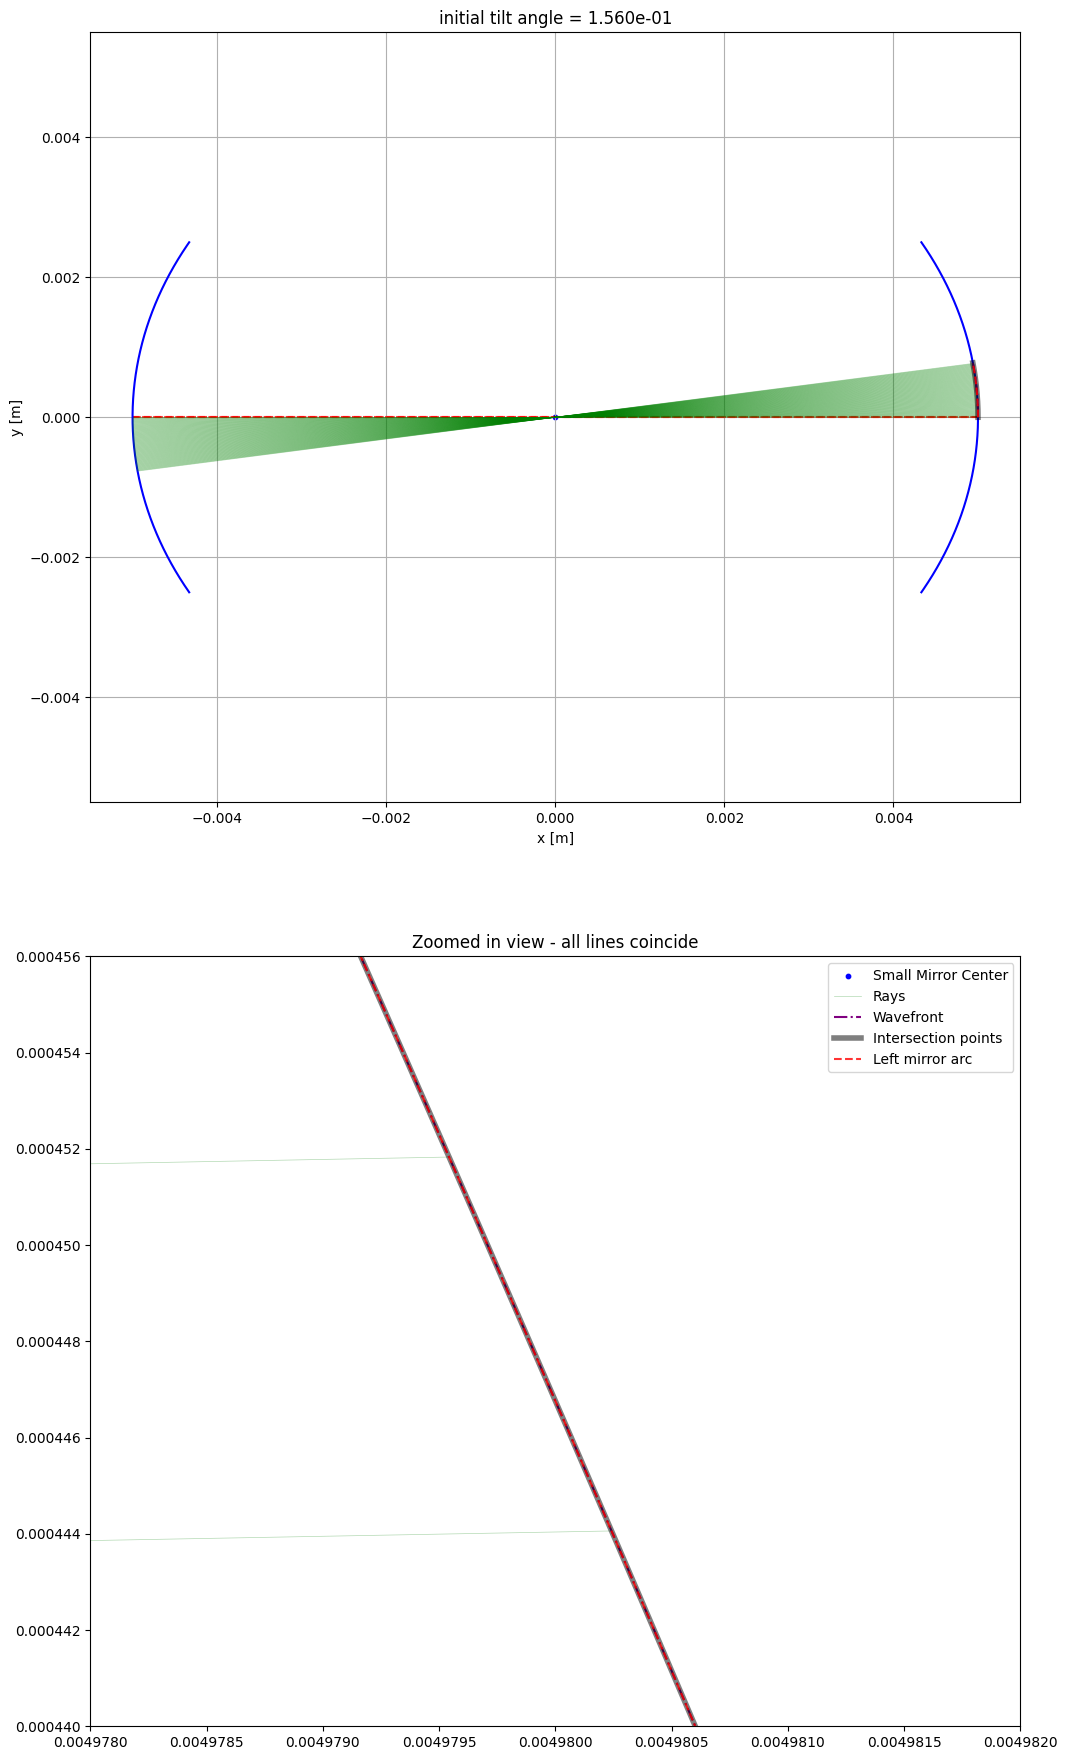

In [3]:
cavity_fabry_perot = fabry_perot_generator(radii=(5e-3, 5e-3), unconcentricity=0e-6, set_mode_parameters=False)
left_mirror, right_mirror, tilt_angles, ray_history, intersection_points, intersection_directions, intersection_normals, sin_abs_theta, \
        incidence_angles, incremental_arc_lengths, integrated_arc_lengths, integrated_divergence, \
        points_of_equal_phase_values, points_of_equal_phase_values_distance_from_face = find_wavefront_deviation(cavity=cavity_fabry_perot, max_initial_angle=0.156, n_rays=10000)

plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 22))
cavity_fabry_perot.plot(ax=ax[0])
ax[0].scatter(right_mirror.origin[0], right_mirror.origin[1], color='blue', s=10, label='Small Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[0], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")

ax[1].scatter(right_mirror.origin[0], right_mirror.origin[1], color='blue', s=10, label='Small Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[1], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")


ax[0].set_title(f"initial tilt angle = {tilt_angles[-1]:.3e}")
ax[0].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
ax[1].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
# plot a circle with radius equal to left mirror.radius and around left mirror origin:
ax[0].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)
ax[1].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)

# plot an arc with the radius of the right arm, with angle between -0.156 to 0.156:
theta_min = np.min(tilt_angles)
theta_max = np.max(tilt_angles)
theta = np.linspace(theta_min, theta_max, 200)
center = left_mirror.origin[:2]
r = left_mirror.radius
arc_x = center[0] + r * np.cos(theta)
arc_y = center[1] + r * np.sin(theta)
ax[0].plot(arc_x, arc_y, color='red', linewidth=1.5, linestyle='--', label='Left mirror arc', alpha=0.8)
ax[1].plot(arc_x, arc_y, color='red', linewidth=1.5, linestyle='--', label='Left mirror arc', alpha=0.8)

ax[1].set_ylim(0.000440, 0.000456)
ax[1].set_xlim(4.98e-3 - 2e-6, 4.98e-3+2e-6)
ax[1].legend()
ax[1].set_title(f"Zoomed in view - all lines coincide")

print(f"wavefront distance from right mirror: (both are practically 0, with different numerical errors)")
print(f"wavefront distance from mirror according to wave front tracing = {points_of_equal_phase_values_distance_from_face[-1]:.3e}m")
print(f"wavefront distance from mirror according to angle of incidence integration = {integrated_divergence[-1]:.3e}m")



### This cells shows that unconcentricity initialization of the fabry perot cavity works as expected (resulted numerical NA matches analytic expression):

Text(0.5, 1.0, 'unconcentricity=2e-06\nCalculated NA (numerics): 6.921e-02\nExpected NA (analytic expression): 6.921e-02')

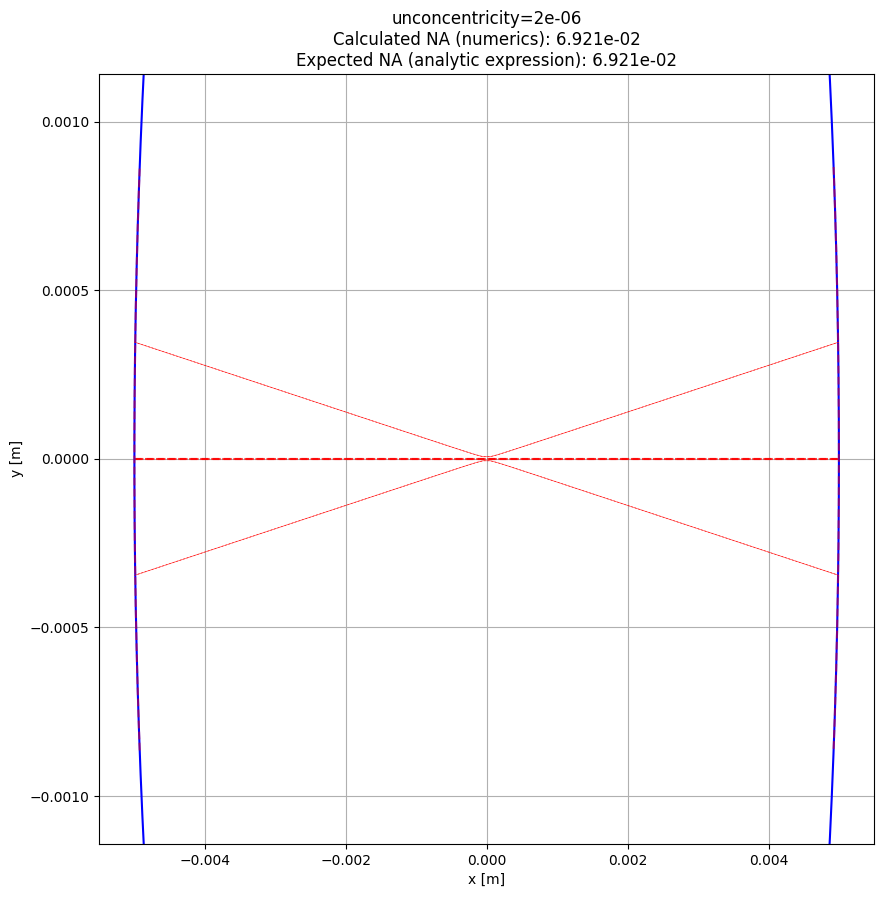

In [4]:
unconcentricity_value = 2e-6
cavity_fabry_perot = fabry_perot_generator(radii=(5e-3, 5e-3), unconcentricity=unconcentricity_value, set_mode_parameters=True)
cavity_fabry_perot.plot()
expected_NA = np.sqrt((2 * LAMBDA_0_LASER) / np.pi) * (unconcentricity_value * np.linalg.norm(cavity_fabry_perot.physical_surfaces[0].center - cavity_fabry_perot.physical_surfaces[1].center)) **(-1/4)
plt.title(f"unconcentricity={unconcentricity_value:.0e}\nCalculated NA (numerics): {cavity_fabry_perot.arms[0].mode_parameters.NA[0]:.3e}\nExpected NA (analytic expression): {expected_NA:.3e}")

### Ray tracing and wavefront tracing for the unconcentric fabry perot cavity:

wavefront distance from right mirror: (both are equal, so different methods agree):
wavefront distance from mirror according to wave front tracing (for some ray) = -2.428e-08m
wavefront distance from mirror according to angle of incidence integration (for some ray) = 2.428e-08m


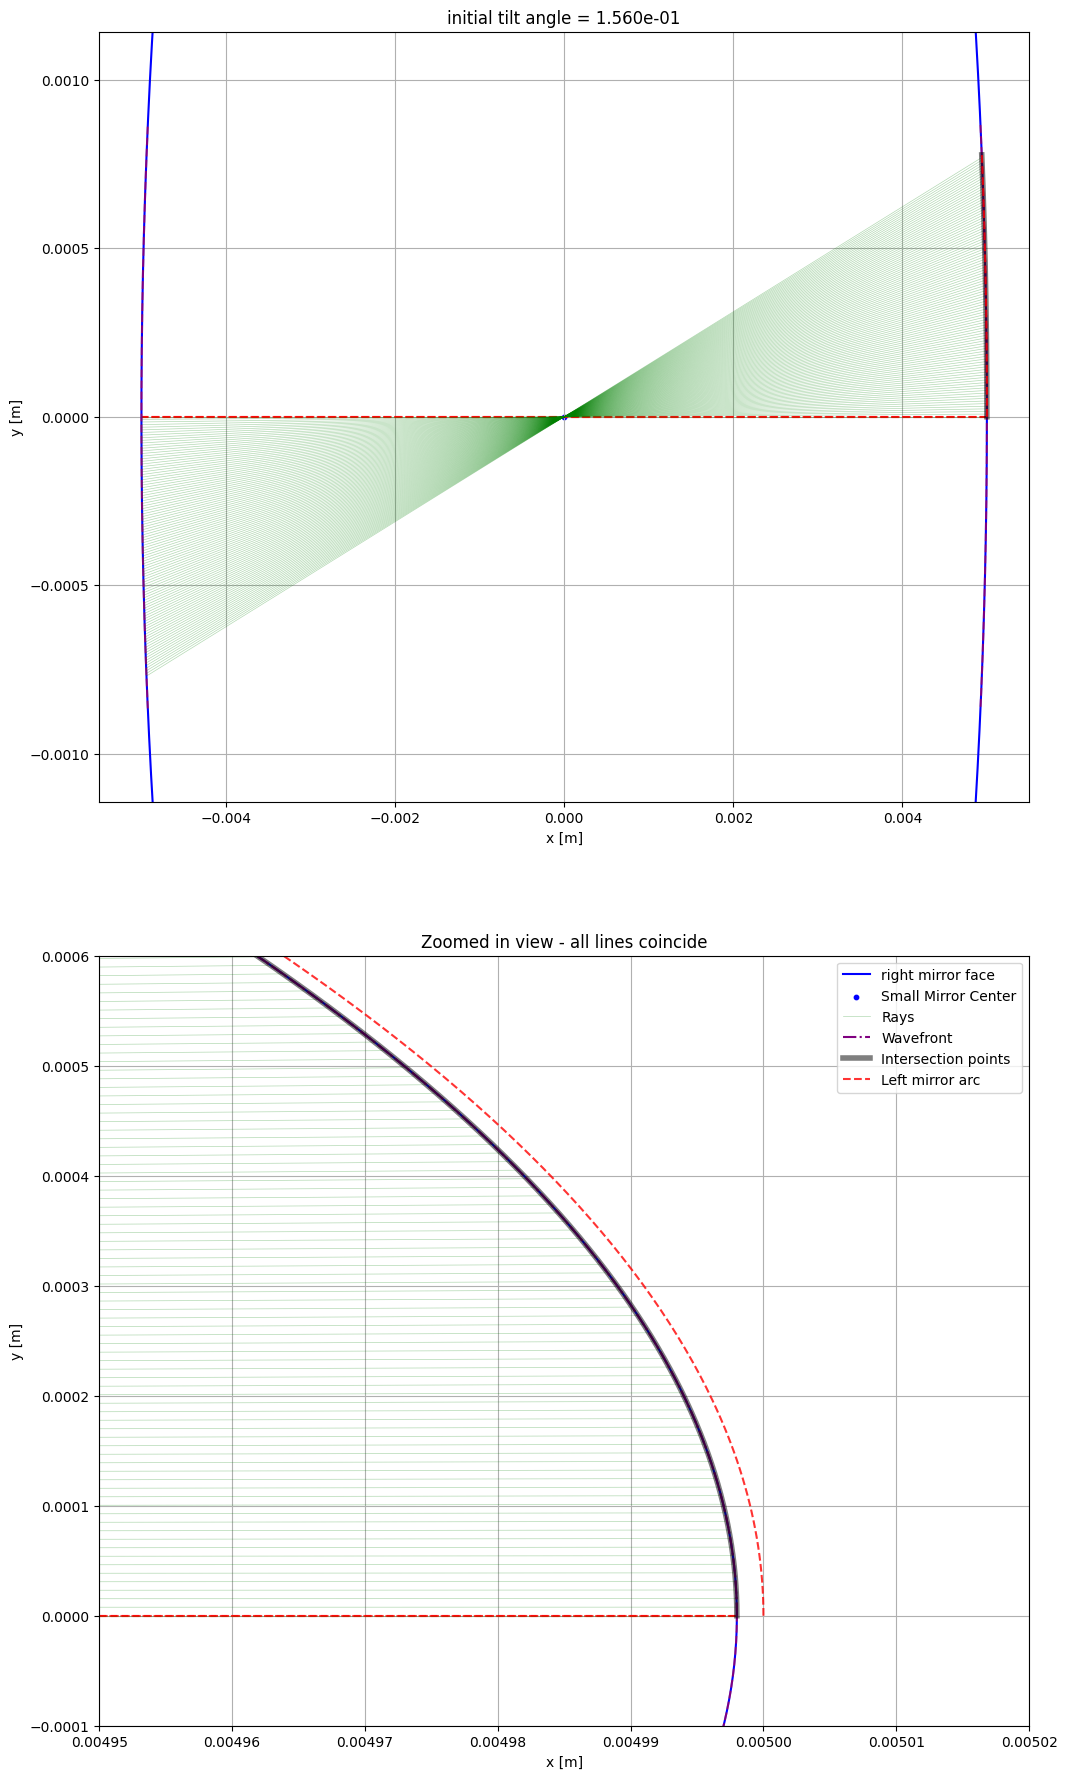

In [6]:
left_mirror, right_mirror, tilt_angles, ray_history, intersection_points, intersection_directions, intersection_normals, sin_abs_theta, \
        incidence_angles, incremental_arc_lengths, integrated_arc_lengths, integrated_divergence, \
        points_of_equal_phase_values, points_of_equal_phase_values_distance_from_face = find_wavefront_deviation(cavity=cavity_fabry_perot, max_initial_angle=0.156, n_rays=10000)

plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 22))
cavity_fabry_perot.plot(ax=ax[0], label="right mirror face", plot_mode_lines=False)
cavity_fabry_perot.plot(ax=ax[1], label="right mirror face", plot_mode_lines=False)
ax[0].scatter(right_mirror.origin[0], right_mirror.origin[1], color='blue', s=10, label='Small Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[0], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")

ax[1].scatter(right_mirror.origin[0], right_mirror.origin[1], color='blue', s=10, label='Small Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[1], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")


ax[0].set_title(f"initial tilt angle = {tilt_angles[-1]:.3e}")
ax[0].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
ax[1].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
# plot a circle with radius equal to left mirror.radius and around left mirror origin:
ax[0].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)
ax[1].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)

# plot an arc with the radius of the right arm, with angle between -0.156 to 0.156:
theta_min = np.min(tilt_angles)
theta_max = np.max(tilt_angles)
theta = np.linspace(theta_min, theta_max, 200)
center = left_mirror.origin[:2]
r = left_mirror.radius
arc_x = center[0] + r * np.cos(theta)
arc_y = center[1] + r * np.sin(theta)
ax[0].plot(arc_x, arc_y, color='red', linewidth=1.5, linestyle='--', label='Left mirror arc', alpha=0.8)
ax[1].plot(arc_x, arc_y, color='red', linewidth=1.5, linestyle='--', label='Left mirror arc', alpha=0.8)

ax[1].set_ylim(-0.0001, 0.0006)
ax[1].set_xlim(0.00495, 0.00502)
leg = ax[1].legend()
handles, labels = leg.legend_handles, [t.get_text() for t in leg.texts]
# remove the second one (index 1)
del handles[0]
del labels[0]
ax[1].legend(handles, labels)

ax[1].set_title(f"Zoomed in view - all lines coincide")

print(f"wavefront distance from right mirror: (both are equal, so different methods agree):")
print(f"wavefront distance from mirror according to wave front tracing (for some ray) = {points_of_equal_phase_values_distance_from_face[-1]:.3e}m")
print(f"wavefront distance from mirror according to angle of incidence integration (for some ray) = {integrated_divergence[-1]:.3e}m")

### Initialize a mirror-lens-mirror cavity with a given unconcentricity for the king arm (should have no mode for 0 unconcentricity, and a diverging mode for small non-zero unconcentricity):

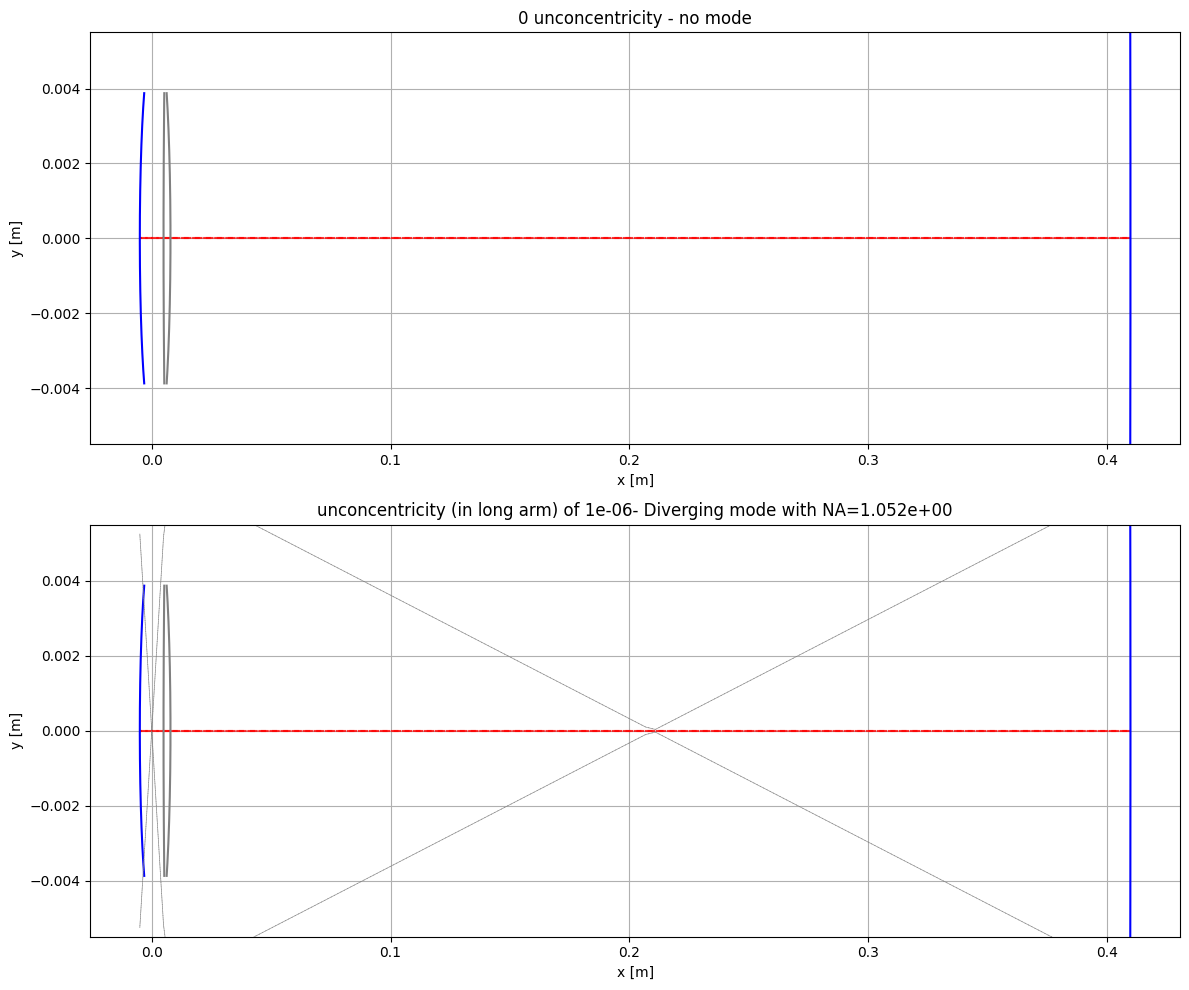

In [7]:
# %%
unconcentricity_value=1e-6
cavity_unconcentricity_0 = mirror_lens_mirror_generator_with_unconcentricity(unconcentricity=0e-6, base_params=params)
cavity_unconcentricity_0.plot()
cavity_unconcentricity_small = mirror_lens_mirror_generator_with_unconcentricity(unconcentricity=unconcentricity_value, base_params=params)
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
cavity_unconcentricity_0.plot(ax=ax[0])
cavity_unconcentricity_small.plot(ax=ax[1])
ax[0].set_title(f"0 unconcentricity - no mode")
ax[1].set_title(f"unconcentricity (in long arm) of {unconcentricity_value:.0e}- Diverging mode with NA={cavity_unconcentricity_small.arms[0].mode_parameters.NA[0]:.3e}")
fig.tight_layout()

Aberrations wavefront deviation for the cavity with 0 unconcentricity:

wavefront distance from right mirror: (both are practically 0, with different numerical errors)
wavefront distance from mirror according to wave front tracing = 1.803e-06m
wavefront distance from mirror according to angle of incidence integration = 1.804e-06m


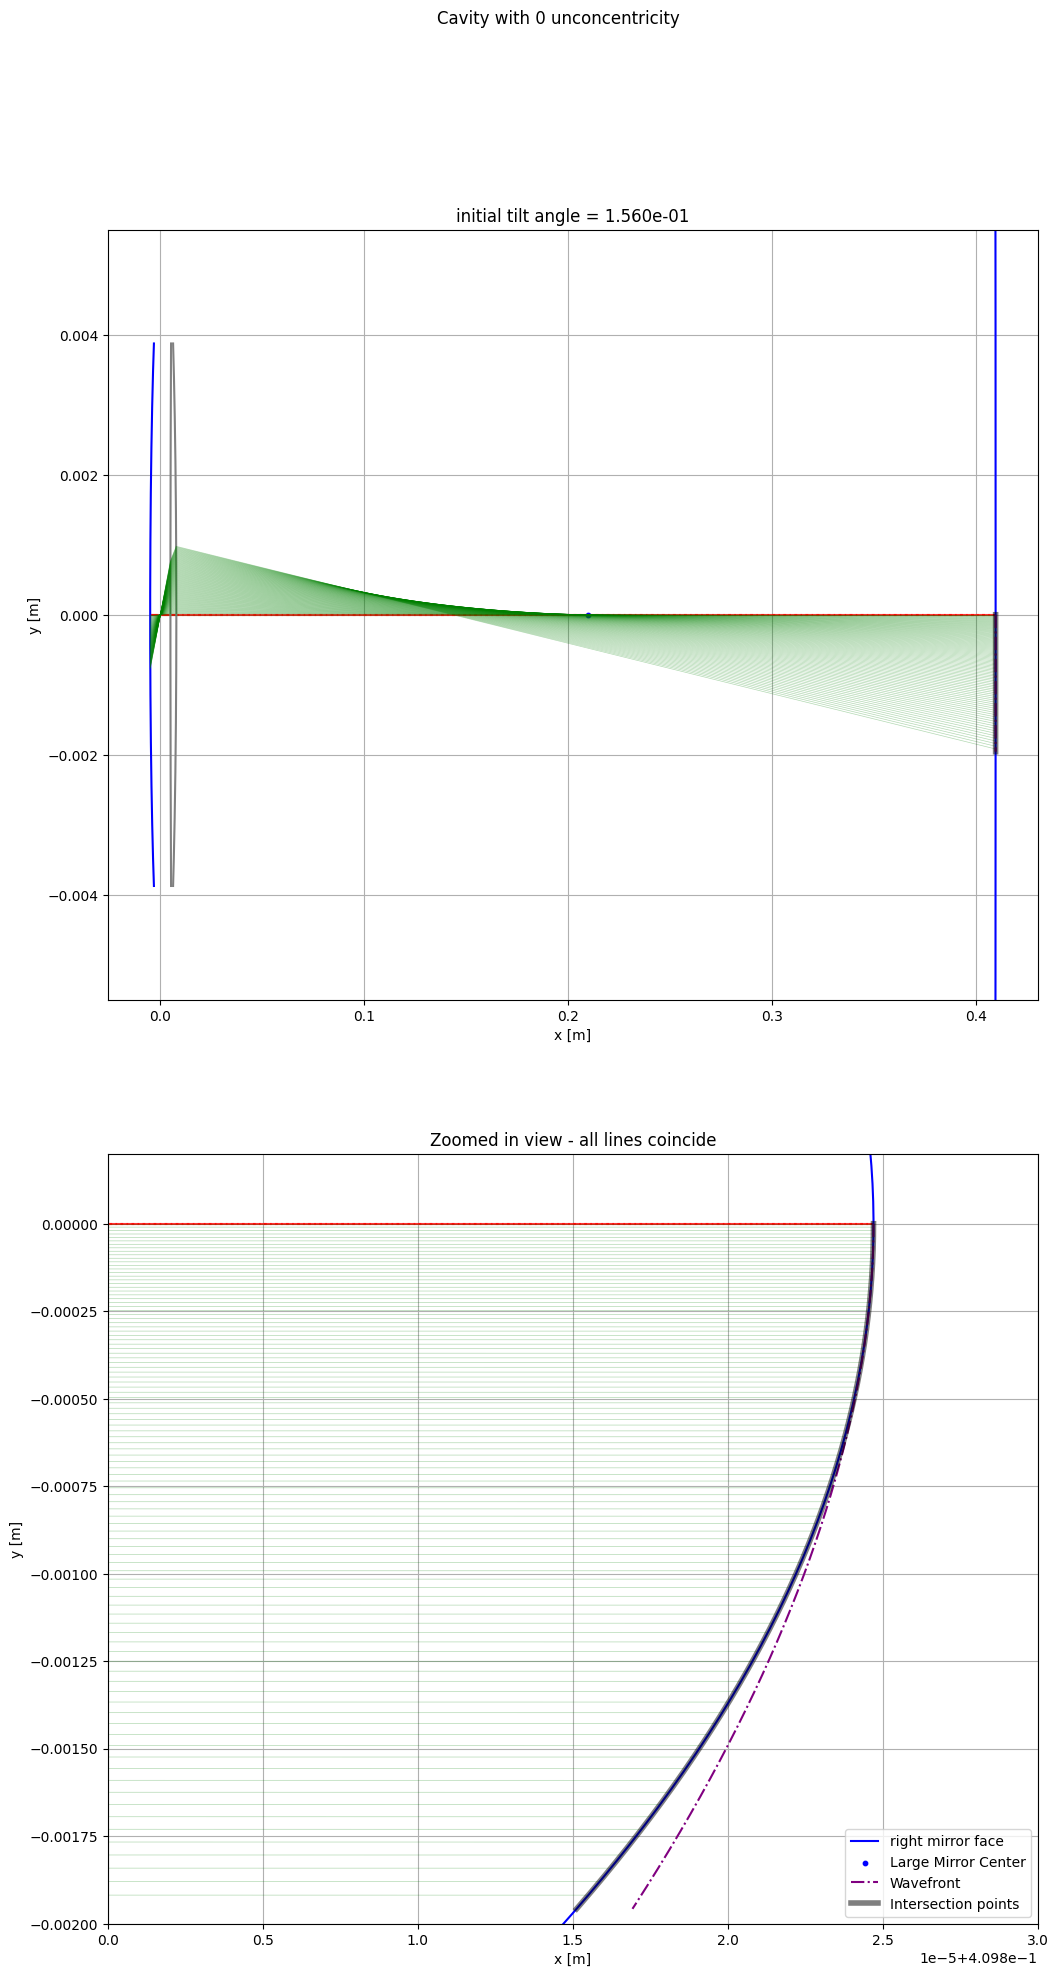

In [8]:
small_mirror, large_mirror, tilt_angles, ray_history, intersection_points, intersection_directions, intersection_normals, sin_abs_theta, \
        incidence_angles, incremental_arc_lengths, integrated_arc_lengths, integrated_divergence, \
        points_of_equal_phase_values, points_of_equal_phase_values_distance_from_face = find_wavefront_deviation(
    cavity=cavity_unconcentricity_0, max_initial_angle=0.156, n_rays=10000)

# %% Plot everything for cavity with 0 unconcentricity:
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 22))
cavity_unconcentricity_0.plot(ax=ax[0])
ax[0].scatter(large_mirror.origin[0], large_mirror.origin[1], color='blue', s=10, label='Large Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[0], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")

cavity_unconcentricity_0.plot(ax=ax[1], label="right mirror face")
ax[1].scatter(large_mirror.origin[0], large_mirror.origin[1], color='blue', s=10, label='Large Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[1], color='green', linewidth=0.5, alpha=0.3)


ax[0].set_title(f"initial tilt angle = {tilt_angles[-1]:.3e}")
ax[0].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
ax[1].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
# plot a circle with radius equal to left mirror.radius and around left mirror origin:
ax[0].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)
ax[1].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)

ax[1].set_ylim(-0.002, 0.0002)
ax[1].set_xlim(0.40980, 0.40983)
ax[1].legend()
ax[1].set_title(f"Zoomed in view - all lines coincide")
fig.suptitle(f"Cavity with 0 unconcentricity")

leg = ax[1].legend()
handles, labels = leg.legend_handles, [t.get_text() for t in leg.texts]
# remove the second one (index 1)
del handles[0:3]
del labels[0:3]
ax[1].legend(handles, labels)
print(f"wavefront distance from right mirror: (both are practically 0, with different numerical errors)")
print(f"wavefront distance from mirror according to wave front tracing = {points_of_equal_phase_values_distance_from_face[-1]:.3e}m")
print(f"wavefront distance from mirror according to angle of incidence integration = {integrated_divergence[-1]:.3e}m")

### Aberratmions wavefront deviation for the cavity with a small unconcentricity:

wavefront distance from right mirror: (both are practically 0, with different numerical errors)
wavefront distance from mirror according to wave front tracing = 1.803e-06m
wavefront distance from mirror according to angle of incidence integration = 1.804e-06m


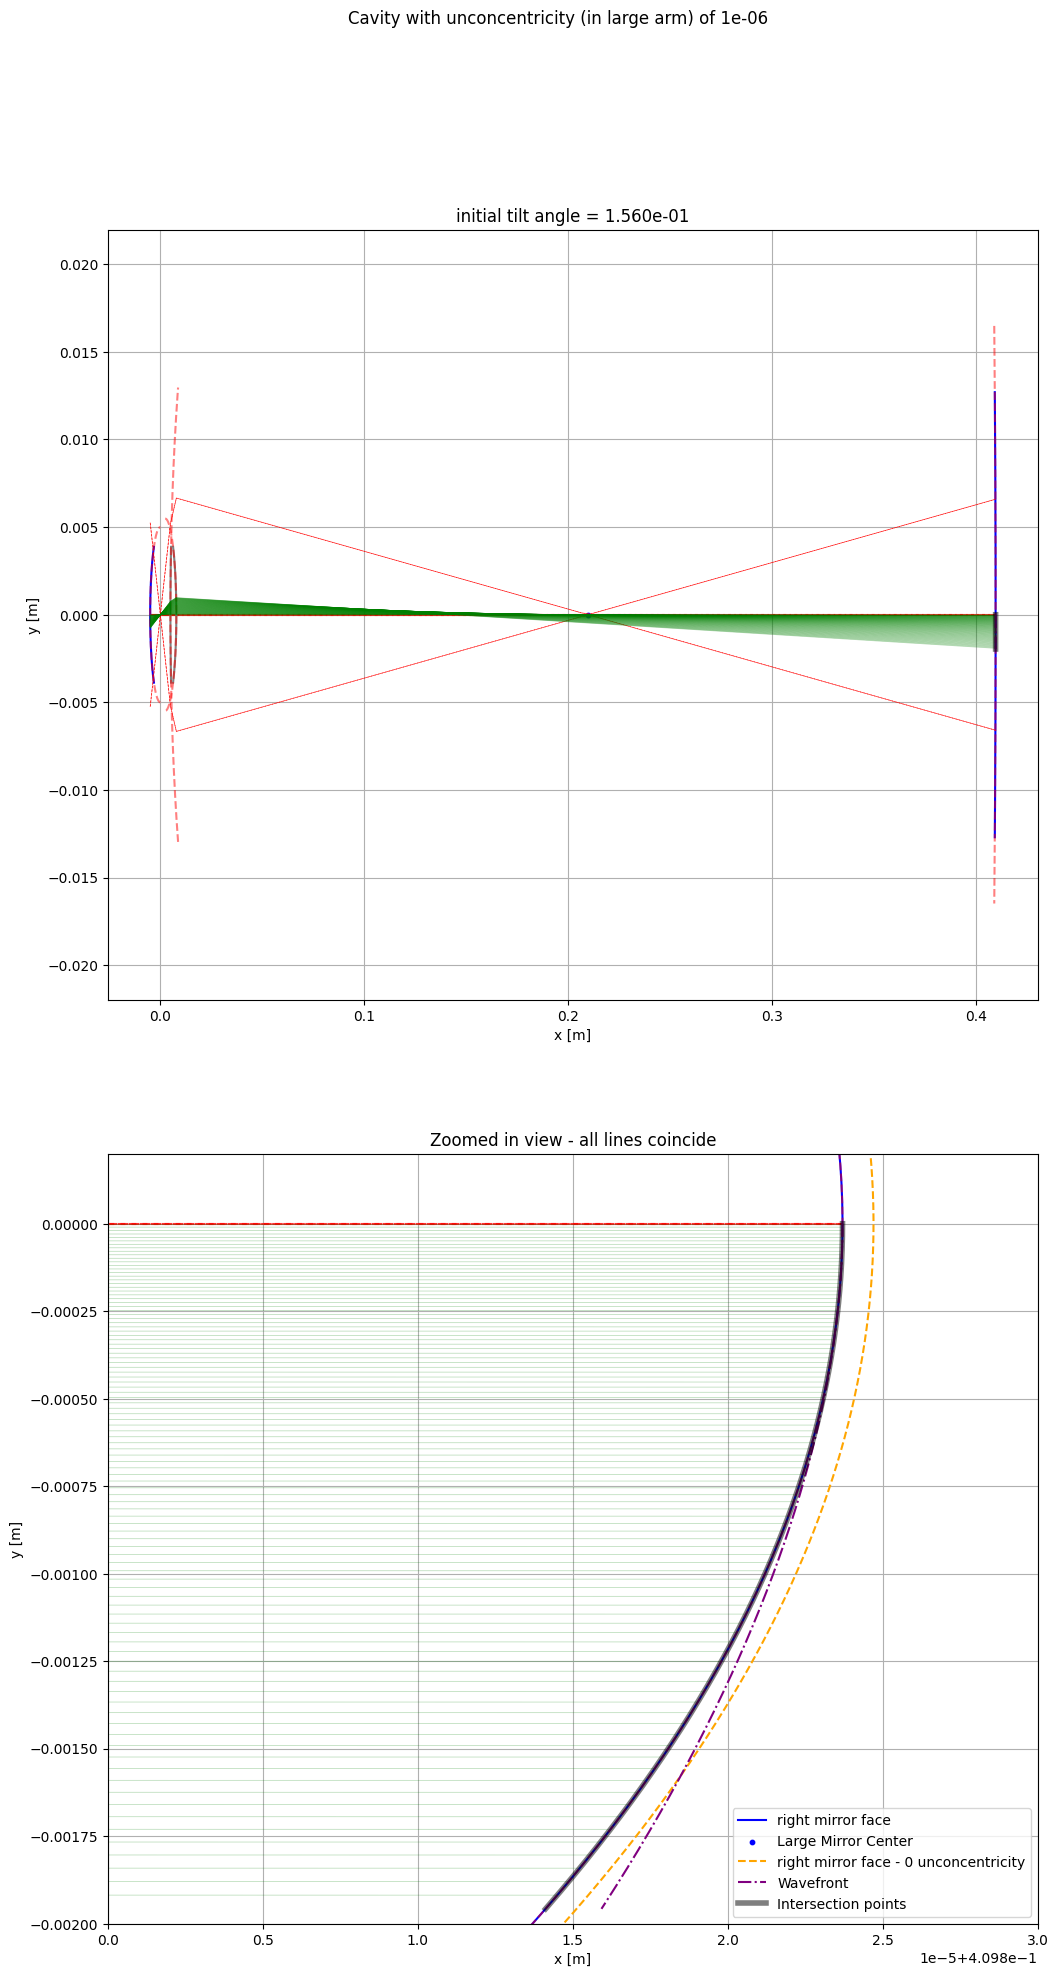

In [11]:
small_mirror, large_mirror, tilt_angles, ray_history, intersection_points, intersection_directions, intersection_normals, sin_abs_theta, \
        incidence_angles, incremental_arc_lengths, integrated_arc_lengths, integrated_divergence, \
        points_of_equal_phase_values, points_of_equal_phase_values_distance_from_face = find_wavefront_deviation(
    cavity=cavity_unconcentricity_small, max_initial_angle=0.156, n_rays=10000)

# %% Plot everything for cavity with finite unconcentricity:
plt.close('all')
fig, ax = plt.subplots(2, 1, figsize=(12, 22))
cavity_unconcentricity_small.plot(ax=ax[0], plot_mode_lines=True)
ax[0].scatter(large_mirror.origin[0], large_mirror.origin[1], color='blue', s=10, label='Large Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[0], color='green', linewidth=0.5, alpha=0.3, label='Rays' if i == 0 else "")

cavity_unconcentricity_small.plot(ax=ax[1], label="right mirror face")
ax[1].scatter(large_mirror.origin[0], large_mirror.origin[1], color='blue', s=10, label='Large Mirror Center')
for i in np.arange(0, len(tilt_angles), 100):
    for ray in ray_history[:-1]:
        ray[i].plot(ax=ax[1], color='green', linewidth=0.5, alpha=0.3)
cavity_unconcentricity_0.physical_surfaces[-1].plot(ax=ax[1], label="right mirror face - 0 unconcentricity", color='orange', linestyle='--')

ax[0].set_title(f"initial tilt angle = {tilt_angles[-1]:.3e}")
ax[0].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
ax[1].plot(points_of_equal_phase_values[:, 0], points_of_equal_phase_values[:, 1], color='purple', linestyle='-.', label='Wavefront')
# plot a circle with radius equal to left mirror.radius and around left mirror origin:
ax[0].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)
ax[1].plot(intersection_points[:, 0], intersection_points[:, 1], color='black', linewidth=4, linestyle='-', label='Intersection points', alpha=0.5)

ax[1].set_ylim(-0.002, 0.0002)
ax[1].set_xlim(0.40980, 0.40983)
ax[1].legend()
ax[1].set_title(f"Zoomed in view - all lines coincide")
fig.suptitle(f"Cavity with unconcentricity (in large arm) of {unconcentricity_value:.0e}")

leg = ax[1].legend()
handles, labels = leg.legend_handles, [t.get_text() for t in leg.texts]
del handles[0:3]
del labels[0:3]
ax[1].legend(handles, labels)
print(f"wavefront distance from right mirror: (both are practically 0, with different numerical errors)")
print(f"wavefront distance from mirror according to wave front tracing = {points_of_equal_phase_values_distance_from_face[-1]:.3e}m")
print(f"wavefront distance from mirror according to angle of incidence integration = {integrated_divergence[-1]:.3e}m")